In [1]:
import pandas as pd
import graphviz as gv
import matplotlib.pyplot as plt

In [102]:
# events — датасет с событиями. Колонки:

# timestamp — время события
# visitorid — идентификатор пользователя
# event — тип события
# itemid — идентификатор объекта
# transactionid — идентификатор транзакции, если она проходила
dfev=pd.read_csv('events.csv.zip')
# добавление читаемого столбца даты/времени
dfev['datetime'] = pd.to_datetime(dfev['timestamp'], unit='ms')

dfev.head()

,timestamp,visitorid,event,itemid,transactionid,datetime
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106


In [85]:
duplicates = dfev.index.duplicated()

if any(duplicates):
    print("Датасет содержит повторяющиеся индексы.")
    print("Индексы, которые дублируются:", dfev.index[duplicates])
else:
    print("Датасет не содержит повторяющихся индексов.")

Датасет не содержит повторяющихся индексов.


In [3]:
# уникальные события
dfev['event'].unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

In [77]:
# подготовка сета с законченными транзацкиями
dfev_tr = dfev[dfev['transactionid'].notna()]
dfev_tr.head()

,timestamp,visitorid,event,itemid,transactionid,datetime
130,1433222276276,599528,transaction,356475,4000.0,2015-06-02 05:17:56.276
304,1433193500981,121688,transaction,15335,11117.0,2015-06-01 21:18:20.981
418,1433193915008,552148,transaction,81345,5444.0,2015-06-01 21:25:15.008
814,1433176736375,102019,transaction,150318,13556.0,2015-06-01 16:38:56.375
843,1433174518180,189384,transaction,310791,7244.0,2015-06-01 16:01:58.180


In [5]:
# разбивка транзакционной выборки на до и после 1 июля
df_before = dfev_tr[dfev_tr['datetime'] <= pd.Timestamp('2015-07-01')]
df_after = dfev_tr[dfev_tr['datetime'] > pd.Timestamp('2015-07-01')]

# топ 3 товара, проданных до 1 июля включительно
top_items = df_before['itemid'].value_counts().head(3)
top_items

119736    36
369447    31
7943      30
Name: itemid, dtype: int64

In [6]:
# (после первого июля уже были другие товары в топе)
top_items_ = df_after['itemid'].value_counts().head(3)
top_items_

461686    110
213834     89
119736     61
Name: itemid, dtype: int64

In [7]:
# полное количество транзакций до 1 июля
total_transactions = len(df_before)

# доля продаж топ 3 товаров в общем кол-ве транзакций до 1 июля
percentage_top_items = (top_items.sum() / total_transactions) * 100

print("\nдоля(%) продаж топ 3 товаров в общем кол-ве транзакций до 1 июля: {:.2f}%".format(percentage_top_items))


доля(%) продаж топ 3 товаров в общем кол-ве транзакций до 1 июля: 1.00%


In [9]:
# всего продаж после 1 июля
total_transactions_after = len(df_after)
# получим список itemid, которые входили в топ 3 до 1 июля
top_items_list = list(top_items.index)
# определить количество транзакций после 1 июля с топами из до 1 июля
top_items_count_after = df_after[df_after['itemid'].isin(top_items_list)].shape[0]

# какая доля продаж после 1 июля бывших топов
percentage_top_items_after = (top_items_count_after / total_transactions_after) * 100

print("\nдоля(%) продаж бывших топ 3 товаров в общем кол-ве транзакций после 1 июля: {:.3f}%".format(percentage_top_items_after))


доля(%) продаж бывших топ 3 товаров в общем кол-ве транзакций после 1 июля: 0.601%


In [19]:
# category_tree — файл с деревом категорий (можно восстановить дерево).
# category_id — идентификатор категорий
# parent_id — идентификатор родительской категории
df=pd.read_csv('category_tree.csv')
df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [38]:
# для корректности сопоставления categoryid	и parentid преобразуем в int
df['parentid'] = df['parentid'].fillna(-1).astype('int64')
df.sample(5)

,categoryid,parentid
1332,750,673
441,426,872
1485,1288,1182
1497,1507,1157
1595,1406,203


In [45]:
#построение графа для дерева категорий/подкатегорий
#(не для всех, а в качестве примера для одной из первых)
def find_root_category(category_id, df):#проверка, что категория входит в текущее дерево
    while True:
        parent_id = df.loc[df['categoryid'] == category_id, 'parentid'].iloc[0]
        if parent_id==-1:
            return category_id
        category_id = parent_id

# Получаем список уникальных корневых категорий
# root_categories = df[df['parentid'].isnull()]['categoryid'].tolist()
root_categories = df[df['parentid'] == -1]['categoryid'].tolist()

# Создаем отдельный граф для каждой корневой категории
for idx, root_category in enumerate(root_categories):
    if idx > 1:
        break

    graph = gv.Digraph(format='png')

    # Добавляем узлы (вершины) графа для текущей корневой категории и ее подкатегорий
    for index, row in df.iterrows():
        category_id = row['categoryid']
        parent_id = row['parentid']

        # Проверяем, что категория входит в дерево и ее корень соответствует текущей корневой категории
        if find_root_category(category_id, df) == root_category:
            if parent_id==-1:
                graph.node(str(category_id), label=f"{category_id} (Root)")
            else:
                graph.node(str(category_id), label=f"{category_id}")
                graph.edge(str(parent_id), str(category_id))

    # Сохраняем построенный граф в файл
    graph.render(f'category_graph_{idx}', view=True)


![](category_graph_1.png)

In [46]:
# item_properties — файл с свойствами товаров.

# timestamp — момент записи значения свойства
# item_id — идентификатор объекта
# property — свойство, кажется, они все, кроме категории, захешированы
# value — значение свойства
dfit1=pd.read_csv('item_properties_part1.csv.zip')
dfit1.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [47]:
dfit2=pd.read_csv('item_properties_part2.csv.zip')
dfit2.head()

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062


In [48]:
# li1=dfit1['property'].unique().tolist()
# li2=dfit2['property'].unique().tolist()
# количество уникальных свойств товаров суммарно по двум сетам
se = set(dfit1['property'].unique()).union(set(dfit2['property'].unique()))
len(se)

1104

In [49]:
# (в двух сетах есть повторяющиеся свойства)
len(dfit1['property'].unique())+len(dfit2['property'].unique())

2191

In [50]:

# Исследование количества событий до и после 1 июля
events_before_count = len(df_before)
events_after_count = len(df_after)

# Сравнение распределения типов событий до и после 1 июля
events_type_distribution_before = df_before['event'].value_counts()
events_type_distribution_after = df_after['event'].value_counts()

# Анализ популярности товаров
top_popular_items_before = df_before['itemid'].value_counts().head(10)
top_popular_items_after = df_after['itemid'].value_counts().head(10)

# Анализ уникальных пользователей
unique_visitors_before = df_before['visitorid'].nunique()
unique_visitors_after = df_after['visitorid'].nunique()
# Вывод результатов
print("Количество событий до 1 июля:", events_before_count)
print("Количество событий после 1 июля:", events_after_count)
print("\nРаспределение типов событий до 1 июля:")
print(events_type_distribution_before)
print("\nРаспределение типов событий после 1 июля:")
print(events_type_distribution_after)
print("\nТоп популярных товаров до 1 июля:")
print(top_popular_items_before)
print("\nТоп популярных товаров после 1 июля:")
print(top_popular_items_after)
print("\nКоличество уникальных пользователей до 1 июля:", unique_visitors_before)
print("Количество уникальных пользователей после 1 июля:", unique_visitors_after)


Количество событий до 1 июля: 9654
Количество событий после 1 июля: 12803

Распределение типов событий до 1 июля:
transaction    9654
Name: event, dtype: int64

Распределение типов событий после 1 июля:
transaction    12803
Name: event, dtype: int64

Топ популярных товаров до 1 июля:
119736    36
369447    31
7943      30
461686    23
318333    23
17478     22
312728    19
382885    18
48030     16
379520    16
Name: itemid, dtype: int64

Топ популярных товаров после 1 июля:
461686    110
213834     89
119736     61
445351     43
248455     38
334401     28
312728     27
441852     27
48030      25
320130     25
Name: itemid, dtype: int64

Количество уникальных пользователей до 1 июля: 5198
Количество уникальных пользователей после 1 июля: 6643


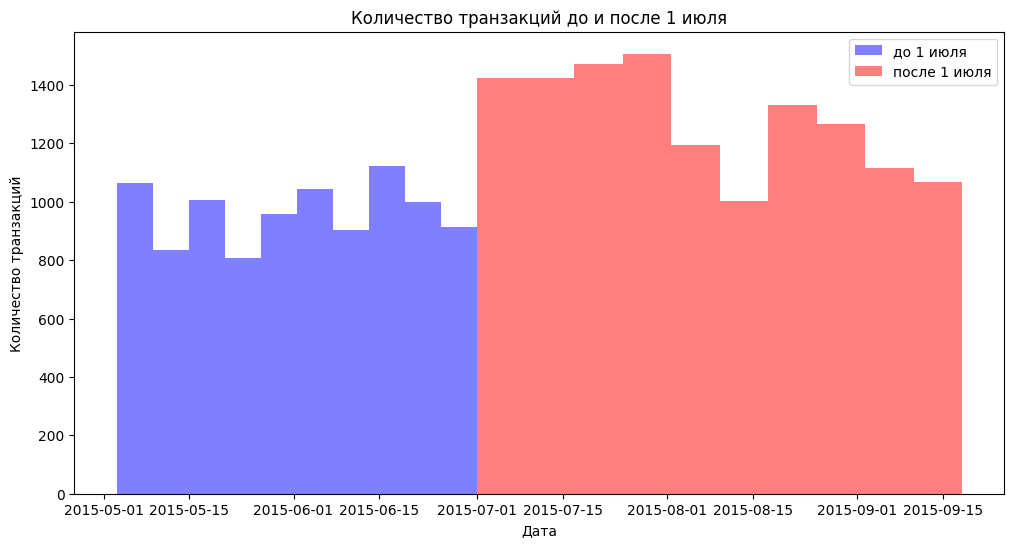

In [44]:

# Создаем гистограмму для количества транзакций до и после 1 июля
plt.figure(figsize=(12, 6))

# Гистограмма для данных до 1 июля
plt.hist(df_before['datetime'], bins=10, alpha=0.5, color='b', label='до 1 июля')

# Гистограмма для данных после 1 июля
plt.hist(df_after['datetime'], bins=10, alpha=0.5, color='r', label='после 1 июля')

plt.xlabel('Дата')
plt.ylabel('Количество транзакций')
plt.title('Количество транзакций до и после 1 июля')
plt.legend()

# Отображаем гистограмму
plt.show()

In [ ]:
# в целом заметно, что интенсивность продаж во втором периоде больше

In [54]:
# проверить корректность датасета - выполняется ли просмотр и добавление в корзину перед транзакцией
def check_order_of_events(df):
    for _, group in df.groupby(['itemid', 'visitorid']):
        has_transaction = any(group['event'] == 'transaction')
        has_addtocart = any(group['event'] == 'addtocart')
        has_view = any(group['event'] == 'view')

        if has_transaction and not has_addtocart:
            return False
        if has_addtocart and not has_view:
            return False

    return True

if check_order_of_events(dfev):
    print("Для каждой комбинации itemid и visitorid существует добавление в корзину перед транзакцией и просмотр перед добавлением в корзину.")
else:
    print("Не для каждой комбинации itemid и visitorid существует добавление в корзину перед транзакцией и просмотр перед добавлением в корзину.")



Не для каждой комбинации itemid и visitorid существует добавление в корзину перед транзакцией и просмотр перед добавлением в корзину.


In [56]:
# если рассуждать, что транзакции должны предшествовать события просмотра и добавления в корзину
# для каждого сочетания товара и покупателя, то следует исключить ряды,
# для которых не было всей цепочки, т.е. транзакция без добавления в корзину, или добавление в корзину без просмотра
# найти такие ряды
def check_order_of_events(df):
    invalid_rows = []

    for _, group in df.groupby(['itemid', 'visitorid']):
        has_transaction = any(group['event'] == 'transaction')
        has_addtocart = any(group['event'] == 'addtocart')
        has_view = any(group['event'] == 'view')

        if has_transaction and not has_addtocart:
            invalid_rows.extend(group.index)
        if has_addtocart and not has_view:
            invalid_rows.extend(group.index)

    return df.loc[invalid_rows]

invalid_rows_df = check_order_of_events(dfev)

if not invalid_rows_df.empty:
    print("Датасет с неверными строками:")
    print(invalid_rows_df)
else:
    print("Нет неверных строк в датасете.")
invalid_rows_df.head(10)    

Датасет с неверными строками:
             timestamp  visitorid        event  itemid  transactionid  \
871355   1439663070866     325833    addtocart      19            NaN   
874476   1439663329849     325833  transaction      19          219.0   
645049   1438647361098     575295  transaction      25         8858.0   
645239   1438647305321     575295    addtocart      25            NaN   
1482986  1430780975099     234788    addtocart      33            NaN   
...                ...        ...          ...     ...            ...   
2439215  1437275507057     702551    addtocart  466740            NaN   
1005231  1440394435722     986471    addtocart  466843            NaN   
2262849  1436646881033     303092    addtocart  466861            NaN   
31858    1433265161227     841595    addtocart  466861            NaN   
728396   1438971634830     651300    addtocart  466864            NaN   

                       datetime  
871355  2015-08-15 18:24:30.866  
874476  2015-08-15 18:28:

,timestamp,visitorid,event,itemid,transactionid,datetime
871355,1439663070866,325833,addtocart,19,NaN,2015-08-15 18:24:30.866
874476,1439663329849,325833,transaction,19,219.0,2015-08-15 18:28:49.849
645049,1438647361098,575295,transaction,25,8858.0,2015-08-04 00:16:01.098
645239,1438647305321,575295,addtocart,25,NaN,2015-08-04 00:15:05.321
1482986,1430780975099,234788,addtocart,33,NaN,2015-05-04 23:09:35.099
1496938,1430780975099,234788,addtocart,33,NaN,2015-05-04 23:09:35.099
1472658,1430679538497,421498,addtocart,33,NaN,2015-05-03 18:58:58.497
2117186,1435941861118,1294980,addtocart,66,NaN,2015-07-03 16:44:21.118
338689,1434576680240,1233979,transaction,212,895.0,2015-06-17 21:31:20.240
343420,1434576582406,1233979,addtocart,212,NaN,2015-06-17 21:29:42.406


In [58]:
# ????
# предположительно из датасета надо исключить 22 тысячи рядов,
# которые не соответствуют логике событий view-addtocart-transaction
invalid_rows_df.to_csv('invalid_rows_df.csv')

In [61]:
# примем решение, считать некорректными только ряды, для которых не было добавления в корзину и были транзакции.
# (если допустить, что можно класть товары в корзину без просмотра)
# Находим все ряды, для которых для сочетания visitorid и itemid нет события addtocart
filtered_df = invalid_rows_df.groupby(['visitorid', 'itemid']).filter(lambda x: not any(x['event'] == 'addtocart'))

print("Ряды, для которых не существует события addtocart для сочетания visitorid и itemid:")
print(filtered_df)
# тогда потребуется удалить порядка 7тыс некорректных рядов

Ряды, для которых не существует события addtocart для сочетания visitorid и itemid:
             timestamp  visitorid        event  itemid  transactionid  \
376542   1434734011664      76757  transaction     320        16619.0   
390533   1434733878627      76757         view     320            NaN   
1007229  1440393876422     434507  transaction     546          408.0   
1011942  1440393693084     434507         view     546            NaN   
2506910  1437508500754     385857  transaction     563        12935.0   
...                ...        ...          ...     ...            ...   
1511731  1430881103410     409939  transaction  465622        17623.0   
47071    1433350379996    1339801  transaction  465943         6395.0   
58886    1433350130723    1339801         view  465943            NaN   
1262617  1441586798593     310032  transaction  466114        10314.0   
1174102  1441148046859    1084561  transaction  466135         8748.0   

                       datetime  
37654

In [103]:
# удалить некорректные ряды
print(dfev.shape)
dfev.drop(filtered_df.index, inplace=True)
print(dfev.shape)

(2756101, 6)
(2749113, 6)


In [65]:
dfev.to_csv('dfev.csv')

In [104]:
# определим конверсию для двух периодов
df_bef = dfev[dfev['datetime'] <= pd.Timestamp('2015-07-01')]
df_aft = dfev[dfev['datetime'] > pd.Timestamp('2015-07-01')]
# отфильтровать ряды, которые удовлетворяют условию, что при группировке по пользователю-товару присутствует транзакция
trans_bef = df_bef.groupby(['visitorid', 'itemid']).filter(lambda x: any(x['event'] == 'transaction'))
trans_bef.head(10)

,timestamp,visitorid,event,itemid,transactionid,datetime
19,1433221078505,158090,addtocart,10572,NaN,2015-06-02 04:57:58.505
27,1433222147345,1076270,view,262799,NaN,2015-06-02 05:15:47.345
112,1433221941632,599528,addtocart,356475,NaN,2015-06-02 05:12:21.632
130,1433222276276,599528,transaction,356475,4000.0,2015-06-02 05:17:56.276
164,1433222646781,529601,view,161166,NaN,2015-06-02 05:24:06.781
304,1433193500981,121688,transaction,15335,11117.0,2015-06-01 21:18:20.981
330,1433191584678,850173,view,243470,NaN,2015-06-01 20:46:24.678
381,1433194701554,539910,view,385201,NaN,2015-06-01 21:38:21.554
418,1433193915008,552148,transaction,81345,5444.0,2015-06-01 21:25:15.008
420,1433193032159,639964,view,360258,NaN,2015-06-01 21:10:32.159


In [106]:
trans_aft = df_aft.groupby(['visitorid', 'itemid']).filter(lambda x: any(x['event'] == 'transaction'))

In [109]:
# Группировка и фильтрация для подсчета количества групп, удовлетворяющих условию
# count_groups = df.groupby(['visitorid', 'itemid']).filter(lambda x: any((x['event'] == 'view') | (x['event'] == 'addtocart'))).groupby(['visitorid', 'itemid']).ngroups

# найти общее количество взаимодействий пользователь-товар
all_bef = df_bef.groupby(['visitorid', 'itemid']).ngroups
all_aft = df_aft.groupby(['visitorid', 'itemid']).ngroups

# найти конверсию
print(f"Конверсия до 1 июля:{trans_bef.groupby(['visitorid', 'itemid']).ngroups/all_bef}")
print(f"Конверсия после 1 июля:{trans_aft.groupby(['visitorid', 'itemid']).ngroups/all_aft}")

Конверсия до 1 июля:0.008934952378995942
Конверсия после 1 июля:0.008818147927898385
